### Agentic RAG
🤖 What is Agentic RAG?

Agentic RAG stands for Agentic Retrieval-Augmented Generation — an advanced version of RAG where instead of a static, one-shot LLM response,the system uses an agent that:

- reasons,
- plans,
- retrieves,
- uses tools,
- and even retries or reflects
to generate better, more grounded answers.

In [1]:
import os
from typing import List, Annotated
from pydantic import BaseModel

from langchain_community.vectorstores import FAISS
from langchain_community.document_loaders import WebBaseLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain.chat_models import init_chat_model
from langchain_openai import OpenAIEmbeddings
from langchain.schema import Document
from langgraph.graph import StateGraph, END

USER_AGENT environment variable not set, consider setting it to identify your requests.


In [2]:
"""
STEP 3: Environment Setup
Load API credentials securely from environment variables.
"""

import os
from dotenv import load_dotenv

# Load environment variables from .env file
load_dotenv()

# Get Google API key with error handling
GOOGLE_API_KEY = os.getenv('GOOGLE_API_KEY')
if not GOOGLE_API_KEY:
    raise ValueError("GOOGLE_API_KEY not found in environment variables")
TAVILY_API_KEY = os.getenv('TAVILY_API_KEY')
if not TAVILY_API_KEY:
    raise ValueError("TAVILY_API_KEY not found in environment variables")

print("✓ API keys loaded successfully")

✓ API keys loaded successfully


In [3]:
from langchain_google_genai import GoogleGenerativeAIEmbeddings, ChatGoogleGenerativeAI

# Initialize Google embeddings model for vector representation
embedding_model = GoogleGenerativeAIEmbeddings(
    model="models/gemini-embedding-001", 
    google_api_key=GOOGLE_API_KEY
)


# Initialize Google's Gemini model for response generation
llm = ChatGoogleGenerativeAI(
    google_api_key=GOOGLE_API_KEY,
    model="gemini-2.0-flash",    # Latest fast Gemini model for quick reranking
    temperature=0,               # Deterministic output for consistency in ranking
    max_tokens=None,            # Use model default token limit
    timeout=None,               # No timeout limit for ranking requests
    max_retries=2,              # Retry failed requests twice
)

print("✓ Gemini model initialized for reranking")

✓ Gemini model initialized for reranking


/home/bjit/Desktop/Storage01/SelfDevelopment/Rag_Course/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
# -----------------------------
# 1. Document Preprocessing
# -----------------------------
urls = [
    "https://lilianweng.github.io/posts/2023-06-23-agent/",
    "https://lilianweng.github.io/posts/2024-04-12-diffusion-video/"
]

loaders = [WebBaseLoader(url) for url in urls]
docs = []
for loader in loaders:
    docs.extend(loader.load())

docs

[Document(metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'title': "LLM Powered Autonomous Agents | Lil'Log", 'description': 'Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.\nAgent System Overview\nIn a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by several key components:\n\nPlanning\n\nSubgoal and decomposition: The agent breaks down large tasks into smaller, manageable subgoals, enabling efficient handling of complex tasks.\nReflection and refinement: The agent can do self-criticism and self-reflection over past actions, learn from mistakes and refine them for future steps, thereby improving the quality of final resu

In [6]:
import time

## Recursive character text splitter and vectorstore
splitter = RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=50)
split_docs = splitter.split_documents(docs)

print(f"Processing {len(split_docs)} document chunks in batches of 5...")

embedding = embedding_model

# Process documents in batches of 5 to respect API limits
batch_size = 5
all_embeddings = []

for i in range(0, len(split_docs), batch_size):
    batch = split_docs[i:i + batch_size]
    print(f"Processing batch {i//batch_size + 1}/{(len(split_docs) + batch_size - 1)//batch_size}")
    
    # Create vectorstore for this batch
    if i == 0:
        # Create initial vectorstore with first batch
        vectorstore = FAISS.from_documents(batch, embedding)
    else:
        # Add remaining batches to existing vectorstore
        batch_vectorstore = FAISS.from_documents(batch, embedding)
        vectorstore.merge_from(batch_vectorstore)
    
    # Wait after every batch of 5 embeddings
    if i + batch_size < len(split_docs):  # Don't wait after the last batch
        print("Waiting 2 seconds before next batch...")
        time.sleep(2)

retriever = vectorstore.as_retriever()
print("✓ Vectorstore and retriever created successfully")

Processing 234 document chunks in batches of 5...
Processing batch 1/47
Waiting 2 seconds before next batch...
Processing batch 2/47
Waiting 2 seconds before next batch...
Processing batch 3/47
Waiting 2 seconds before next batch...
Processing batch 4/47
Waiting 2 seconds before next batch...
Processing batch 5/47
Waiting 2 seconds before next batch...
Processing batch 6/47
Waiting 2 seconds before next batch...
Processing batch 7/47
Waiting 2 seconds before next batch...
Processing batch 8/47
Waiting 2 seconds before next batch...
Processing batch 9/47
Waiting 2 seconds before next batch...
Processing batch 10/47
Waiting 2 seconds before next batch...
Processing batch 11/47
Waiting 2 seconds before next batch...
Processing batch 12/47
Waiting 2 seconds before next batch...
Processing batch 13/47
Waiting 2 seconds before next batch...
Processing batch 14/47
Waiting 2 seconds before next batch...
Processing batch 15/47
Waiting 2 seconds before next batch...
Processing batch 16/47
Waitin

In [7]:
retriever.invoke("What are agents")

[Document(id='87439671-b362-47da-8f7f-4fd9c8943466', metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'title': "LLM Powered Autonomous Agents | Lil'Log", 'description': 'Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.\nAgent System Overview\nIn a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by several key components:\n\nPlanning\n\nSubgoal and decomposition: The agent breaks down large tasks into smaller, manageable subgoals, enabling efficient handling of complex tasks.\nReflection and refinement: The agent can do self-criticism and self-reflection over past actions, learn from mistakes and refine them for future steps, 

In [8]:
# -----------------------------
# 2. Define RAG State
# -----------------------------

class RAGState(BaseModel):
    question: str
    retrieved_docs: List[Document] = []
    answer: str = ""

In [9]:
# -----------------------------
# 3. LangGraph Nodes
# -----------------------------

def retrieve_docs(state: RAGState) -> RAGState:
    docs = retriever.invoke(state.question)
    return RAGState(question=state.question, retrieved_docs=docs)

def generate_answer(state: RAGState) -> RAGState:
    
    context = "\n\n".join([doc.page_content for doc in state.retrieved_docs])
    prompt = f"Answer the question based on the context.\n\nContext:\n{context}\n\nQuestion: {state.question}"
    response = llm.invoke(prompt)
    return RAGState(question=state.question, retrieved_docs=state.retrieved_docs, answer=response.content)

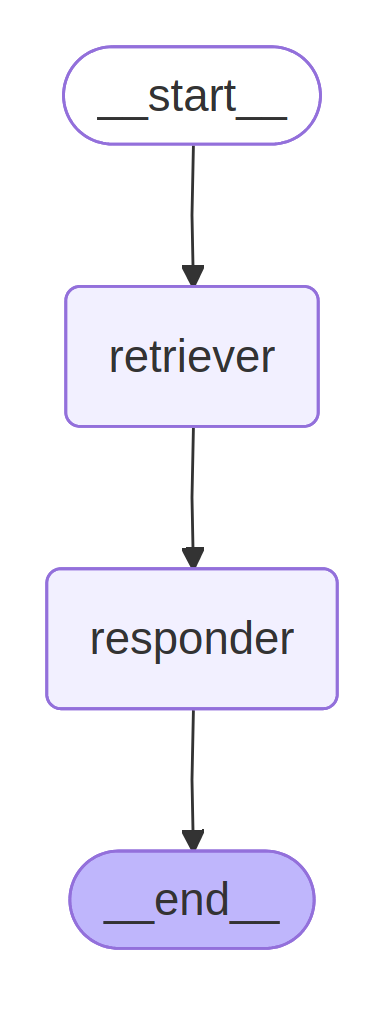

In [ ]:
# -----------------------------
# 4. Build LangGraph
# -----------------------------
from IPython.display import Image, display
from langchain_core.runnables.graph import MermaidDrawMethod 
import nest_asyncio
nest_asyncio.apply()



builder = StateGraph(RAGState)

builder.add_node("retriever", retrieve_docs)
builder.add_node("responder", generate_answer)

builder.set_entry_point("retriever") ## can use START also
builder.add_edge("retriever", "responder")
builder.add_edge("responder", END)

graph = builder.compile()
graph

# View
display(Image(graph.get_graph().draw_mermaid_png(draw_method=MermaidDrawMethod.PYPPETEER)))

In [12]:
# -----------------------------
# 5. Run the Agentic RAG
# -----------------------------

if __name__ == "__main__":
    user_question = "What is the concept of agent loop in autonomous agents?"
    initial_state = RAGState(question=user_question)
    final_state = graph.invoke(initial_state)

    print("\n✅ Final Answer:\n", final_state['answer'])


✅ Final Answer:
 The provided text describes the agent loop in autonomous agents as a process involving "Thought, Action, Observation" repeated multiple times. It also mentions that the agent may decide to reset the environment to start a new trial based on self-reflection results.


### 🤖 What is ReAct?
ReAct (Reasoning + Acting) is a framework where an LLM:

- Reasons step-by-step (e.g. decomposes questions, makes decisions)

- Acts by calling tools like search, calculators, or retrievers

This makes it perfect for Agentic RAG:
✅ Think → Retrieve → Observe → Reflect → Final Answer